#### Funcitons (IGNORE)

In [27]:
# import packages that will be used for analysis
import random
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(4)
np.random.seed(4)

##### Get Stock Data

In [28]:
import yfinance as yf
missing_data_tickers = [] # use this as a list of tickers with missing data

def get_data_from_start_to_end(ticker, start_date, end_date):
    global missing_data_tickers  # Use the global list to accumulate missing tickers
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            missing_data_tickers.append(ticker)
            raise ValueError(f"Stock data for ticker {ticker} during the period from {start_date} to {end_date} was not found.")
        return stock_data
    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")
        missing_data_tickers.append(ticker)
        return None


In [29]:
# for a variety of periods load in different list of tickers
def download_stock_data_for_periods(tickers, periods):
    all_data = {}
    
    for period, (start_date, end_date) in periods.items():
        period_data = {}
        for ticker in tickers:
            data = get_data_from_start_to_end(ticker, start_date, end_date)
            if data is not None:
                period_data[ticker] = data
        all_data[period] = period_data
    
    return all_data

In [30]:
import pandas as pd

# Get the adjusted close prices
adj_close_sector_etf = {}

# Create adjusted close price only listing of sector ETFs
def get_adjusted_closed_price(nested_dict, tickers, periods):
    for period in periods:
        stock_price_df = pd.DataFrame()  # Create a new DataFrame for each period
        for ticker in tickers:
            stock_price_df[ticker] = nested_dict[period][ticker]['Adj Close']
        
        adj_close_sector_etf[period] = stock_price_df  # Store the complete DataFrame for the period
    
    return adj_close_sector_etf

##### MACD Signal

In [31]:
def macd_components(nested_dict,periods,tickers,short_ema,long_ema,signal_line):
    for period in periods:
        for ticker in tickers:
            # get the short and long ema
            nested_dict[period][ticker]['short_ema'] = nested_dict[period][ticker]['Close'].ewm(span=short_ema, adjust=False).mean()
            nested_dict[period][ticker]['long_ema'] = nested_dict[period][ticker]['Close'].ewm(span=long_ema, adjust=False).mean()

            # create the MACD line
            nested_dict[period][ticker]['macd_line'] = nested_dict[period][ticker]['short_ema'] - nested_dict[period][ticker]['long_ema']
            nested_dict[period][ticker]['signal_line'] = nested_dict[period][ticker]['macd_line'].ewm(span=signal_line, adjust=False).mean()

    return nested_dict

In [32]:
def add_macd_signals(nested_dict, periods, tickers):
    """
    Function to calculate MACD, Signal Line, and generate Buy/Sell signals based on crossovers.
    """
    for period in periods:
        for ticker in tickers:
            data = nested_dict[period][ticker]

            # Ensure MACD and Signal Line are present
            if 'macd_line' in data and 'signal_line' in data:
                # Identify crossovers for Buy (MACD crosses above Signal) or Sell (MACD crosses below Signal)
                data['Signal'] = np.where(
                    (data['macd_line'].shift(1) < data['signal_line'].shift(1)) & (data['macd_line'] > data['signal_line']),
                    'Buy',
                    np.where(
                        (data['macd_line'].shift(1) > data['signal_line'].shift(1)) & (data['macd_line'] < data['signal_line']),
                        'Sell',
                        'Hold'
                    )
                )
    return nested_dict


In [33]:
def collect_signals(nested_dict, periods, tickers):
    # Initialize an empty dictionary to hold DataFrames for each period
    bb_nested_dict = {}

    for period in periods:
        # Create a DataFrame for each period with the tickers as columns
        signals_period = pd.DataFrame(columns=tickers)
        
        # Loop through each ticker and extract the 'Signal'
        for ticker in tickers:
            signals_period[ticker] = nested_dict[period][ticker]['Signal']
        
        # Store the DataFrame in the dictionary using the period as the key
        bb_nested_dict[period] = signals_period

    # Return the dictionary containing DataFrames for each period
    return bb_nested_dict

##### Stochastic Modeling

In [34]:
from datetime import timedelta
import numpy as np
import pandas as pd

def zip_calculate_stock_roi(bb_signals_nd, adj_close_nd, periods_date, periods_list, tickers, n_sample, initial_investment, future_investments, percent_to_buy, percent_to_sell):
    random.seed(4)
    np.random.seed(4)
    # Initialize a nested dictionary to store ROI percentages for each period and ticker
    roi_results = {period: {ticker: [] for ticker in tickers} for period in periods_list}

    # Loop through each economic period
    for period in periods_list:
        # Create the date range for the current period
        date_range = pd.date_range(start=pd.to_datetime(periods_date[period][0]), end=pd.to_datetime(periods_date[period][1]) - timedelta(days=110))
        
        # Get random dates for stochastic modeling
        start_dates = np.random.choice(date_range, size=n_sample, replace=True)

        # Loop through sampled start dates
        for start_date in start_dates:
            time_stamp = pd.to_datetime(start_date)

            # Extract the adjusted close and signal data for time period
            adj_close_period = adj_close_nd[period].loc[time_stamp:time_stamp + timedelta(days=110)]
            bb_signals_period = bb_signals_nd[period].loc[time_stamp:time_stamp + timedelta(days=110)]

            # Initialize variables for each ticker
            account_balance = {ticker: future_investments for ticker in tickers}  # Separate account balance for each stock
            shares_number = {ticker: initial_investment/adj_close_period[ticker].iloc[0] for ticker in tickers}  # Initialize share count for each ticker
            shares_value = {ticker: initial_investment for ticker in tickers}   # Initialize share value for each ticker

            # Iterate over each day in the Bollinger Band signals and adjusted close prices
            for row_idx, (signals_row, adj_close_row) in enumerate(zip(bb_signals_period.iterrows(), adj_close_period.iterrows())):
                signals_row = signals_row[1]  # Extract the actual row (signals) - don't need the index
                adj_close_row = adj_close_row[1]  # Extract the actual row (adjusted close prices)

                # Now zip over the signal row and the corresponding adjusted close price for each ticker
                for ticker, (signal, adj_close_price) in zip(tickers, zip(signals_row, adj_close_row)):
                    
                    # Handle Buy action
                    if signal == 'Buy':
                        amount_to_buy = percent_to_buy * account_balance[ticker]
                        if account_balance[ticker] >= amount_to_buy:
                            shares_to_buy = amount_to_buy / adj_close_price
                            shares_number[ticker] += shares_to_buy
                            account_balance[ticker] -= amount_to_buy

                    # Handle Sell action
                    elif signal == 'Sell':
                        if shares_number[ticker] > 0:
                            shares_value[ticker] = shares_number[ticker] * adj_close_price
                            amount_to_sell = percent_to_sell * shares_value[ticker]
                            if shares_value[ticker] >= amount_to_sell:
                                shares_to_sell = amount_to_sell / adj_close_price
                                shares_number[ticker] -= shares_to_sell
                                account_balance[ticker] += amount_to_sell

            # Calculate total portfolio value for each stock at the end of the period
            for ticker in tickers:
                if shares_number[ticker] > 0:  # Only calculate value if shares are owned
                    portfolio_value = shares_number[ticker] * adj_close_period.iloc[-1][ticker]
                    total_value = account_balance[ticker] + portfolio_value
                    
                    # Calculate profit for this stock
                    profit = total_value - (initial_investment + future_investments)
                    
                    # Calculate ROI based on stock's individual account
                    roi_dollar_value = (profit / (initial_investment + future_investments)) * 100
                else:
                    roi_dollar_value = 0

                # Store ROI in the results dictionary
                roi_results[period][ticker].append(roi_dollar_value)

    return roi_results

In [35]:
def stochastic_roi(tickers,periods,return_rates_list,analysis_type):
    df = pd.DataFrame(index=tickers,columns=periods)
    for period in periods:
        for ticker in tickers:
            data = pd.Series(return_rates_list[period][ticker])
            if analysis_type=='Mean':
                df.at[ticker,period] = data.mean()
            elif analysis_type=='Median':
                df.at[ticker,period] = data.median()
            elif analysis_type=='Std':
                df.at[ticker,period] = data.std()
            elif analysis_type=='Variance':
                df.at[ticker,period] = data.var()

    return df

In [36]:
from itertools import product
def macd_roi_grid_search(macd_grid, nested_dict, adj_close_nd, periods_date, periods_list, tickers, n_sample, initial_investment, future_investments, percent_to_buy, percent_to_sell):
    """
    Perform a grid search to find the optimal MACD parameters for ROI.

    Args:
    - macd_grid: Dictionary with parameter ranges for short_window, long_window, and signal_window.
    - nested_dict: Nested dictionary containing OHLC data for each period and ticker.
    - adj_close_nd: Nested dictionary with adjusted close prices for each period and ticker.
    - periods_date: Dictionary with start and end dates for each period.
    - periods_list: List of periods for analysis.
    - tickers: List of stock tickers to analyze.
    - n_sample: Number of random samples to test.
    - initial_investment: Initial amount invested in each stock.
    - future_investments: Additional funds allocated during the period.
    - percent_to_buy: Percentage of available funds to buy shares.
    - percent_to_sell: Percentage of current share value to sell.

    Returns:
    - DataFrame with results for each parameter combination and the corresponding ROI.
    """
    results = []

    # Generate all combinations of MACD parameters
    macd_combinations = product(macd_grid['short_window'], macd_grid['long_window'], macd_grid['signal_window'])

    for short_window, long_window, signal_window in macd_combinations:
        data = macd_components(nested_dict,periods_list,tickers,short_window,long_window,signal_window)

        # Generate MACD-based Buy/Sell signals
        data = add_macd_signals(
            nested_dict=data,
            periods=periods_list,
            tickers=tickers
        )

        signals = collect_signals(data,periods_list,tickers)

        # Calculate ROI using the current MACD signals
        roi_results = zip_calculate_stock_roi(
            bb_signals_nd=signals,
            adj_close_nd=adj_close_nd,
            periods_date=periods_date,
            periods_list=periods_list,
            tickers=tickers,
            n_sample=n_sample,
            initial_investment=initial_investment,
            future_investments=future_investments,
            percent_to_buy=percent_to_buy,
            percent_to_sell=percent_to_sell
        )

        # Average ROI across periods and tickers
        average_roi = stochastic_roi(tickers, periods_date, roi_results, 'Mean').mean()

        # Append results
        results.append({
            'short_window': short_window,
            'long_window': long_window,
            'signal_window': signal_window,
            'trough': average_roi[0],
            'expansion': average_roi[1],
            'peak': average_roi[2],
            'contraction': average_roi[3],
            'all_data': average_roi[4],
        })

    # Convert results to a DataFrame
    roi_df = pd.DataFrame(results)
    
    return roi_df


##### Plot data

In [37]:
import matplotlib.pyplot as plt

def plot_macd_signals_combined(macd_data, ticker):
    """
    Visualizes MACD Line, Signal Line, and Buy/Sell signals on the same graph.
    
    Parameters:
    macd_data (pd.DataFrame): DataFrame containing 'Adj Close', 'MACD Line', 'Signal Line', and 'Signal'.
    ticker (str): The stock ticker symbol.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot the adjusted close price
    ax.plot(macd_data.index, macd_data['Adj Close'], label=f'{ticker} Price', color='grey', alpha=0.5)
    ax.set_ylabel('Price', color='grey')
    ax.tick_params(axis='y', labelcolor='grey')
    ax.set_title(f'{ticker} MACD with Price and Signals')

    # Create a secondary y-axis for MACD
    ax2 = ax.twinx()
    
    # Plot the MACD and Signal lines
    ax2.plot(macd_data.index, macd_data['macd_line'], label='MACD Line', color='blue')
    ax2.plot(macd_data.index, macd_data['signal_line'], label='Signal Line', color='red')
    
    # Mark buy and sell signals
    buy_signals = macd_data[macd_data['Signal'] == 'Buy']
    sell_signals = macd_data[macd_data['Signal'] == 'Sell']
    
    ax2.scatter(buy_signals.index, buy_signals['macd_line'], color='green', marker='^', label='Buy Signal', alpha=1)
    ax2.scatter(sell_signals.index, sell_signals['macd_line'], color='red', marker='v', label='Sell Signal', alpha=1)
    
    ax2.axhline(0, color='black', linewidth=0.5, linestyle='--', label='Zero Line')
    ax2.set_ylabel('MACD', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add legends
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
    
    # Format x-axis
    plt.xticks(rotation=60)
    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()

# Chapter 4: Moving Average Convergence Divergence (MACD)
The MACD is another popular technical analysis technique, it concentrates on the momentum of a stock. It has two lines which oscillate between one another. The first line, referred to as the MACD line is found by looking at longer term EMA (typically 26) / shorter term EMA (typically 12). The second line is referred to as the signal line which is typically a 9 day EMA of the MACD line. It can suggest the following:

- Bullish Signal: When the MACD Line crosses above the Signal Line, it can indicate upward momentum, a possible buy signal.
- Bearish Signal: When the MACD Line crosses below the Signal Line, it can indicate downward momentum, a possible sell signal.
- Divergence: Price action diverging from the MACD can signal potential reversals.

### Data Setup

In [38]:
# create time periods for where this takes place
economic_cycle_periods = {

    "trough": ("2008-10-01", "2009-06-01"),
    "expansion": ("2012-01-01", "2015-01-01"),
    "peak": ("2019-06-01", "2020-02-01"),
    "contraction": ("2007-12-01", "2008-10-01"),
    'all_data': ('2005-01-01','2024-06-01')
}

economic_cycle_periods_list = ['trough','expansion','peak','contraction','all_data']

In [39]:
# create etf tickers for sectors
sector_etf_tickers = [
    'XLB', # materials sector
    'XLI', # industrials sector
    'XLF', # financials
    'XLK', # information technology
    'XLY', # consumer discretionary
    'XLP', # consumer staples
    'XLE', # energy
    'XLV', # healthcare
    'VOX', # communication services
    'XLU', # utilities
    'IYR' # real estate
    ]

In [40]:
# save nested dictionary data as a variable to be accessed.
sector_etf_data = download_stock_data_for_periods(sector_etf_tickers,economic_cycle_periods)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

### Moving Average Convergence Divergence Strategy
The MACD technical analysis will create the following parameters:
- Short Exponential Moving Average (12-day)
- Long Exponential Moving Average (26 days)
- MACD Line: Exponential Moving Average difference between Short EMA and Long EMA (9 days)
- Signal Line EMA of the MACD line

By utilizing an exponential moving average it gives a greater weight to the more recent values, this makes it more sensitive to recent changes in price. The MACD line measures the convergence or divergence between fast and slow moving averages. When the MACD line is positive (above 0), the short term trend is stronger than the long term trend which suggests an upwards trend. Where as when the MACD line is negative (below 0) the short term is weaker than the long term trend which suggests downwards momentum.

The signal line is used as the buy and sell signal by smoothing the MACD line using a 9 day ema period. When the MACD line goes above the signal line it indicates a buy signal and the MACD line goes below the signal line it indicates a sell signal.


In [41]:
# create the neccessary macd components
sector_etf_data = macd_components(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers,12,26,9)

add_macd_signals(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)['trough']['XLV']

,Open,High,Low,Close,Adj Close,Volume,short_ema,long_ema,macd_line,signal_line,Signal
Date,,,,,,,,,,,
2008-10-01,30.100000,30.480000,30.100000,30.250000,22.927488,6053600,30.250000,30.250000,0.000000,0.000000,Hold
2008-10-02,30.250000,30.590000,29.930000,30.299999,22.965387,6353400,30.257692,30.253704,0.003989,0.000798,Hold
2008-10-03,30.600000,30.600000,29.650000,29.650000,22.472727,6814400,30.164201,30.208985,-0.044784,-0.008319,Sell
2008-10-06,29.400000,29.879999,27.410000,28.540001,21.631418,8545000,29.914324,30.085356,-0.171032,-0.040861,Hold
2008-10-07,28.719999,28.780001,27.389999,27.850000,21.108438,5060200,29.596736,29.919774,-0.323039,-0.097297,Hold
...,...,...,...,...,...,...,...,...,...,...,...
2009-05-22,25.280001,25.400000,25.070000,25.290001,19.404516,3655700,25.249371,24.937684,0.311688,0.311063,Hold
2009-05-26,25.190001,25.660000,24.889999,25.520000,19.580988,4412900,25.291007,24.980818,0.310188,0.310888,Sell
2009-05-27,25.549999,25.600000,25.219999,25.260000,19.381500,4591100,25.286236,25.001498,0.284738,0.305658,Hold


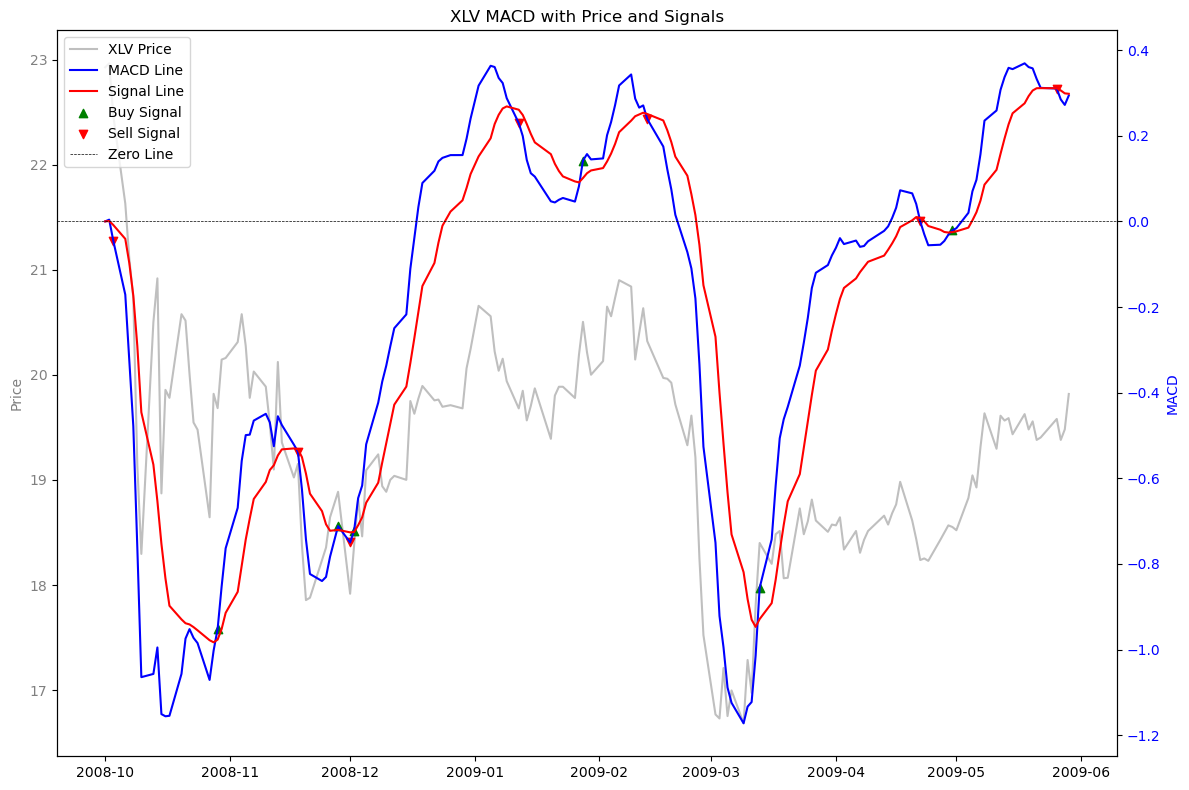

In [42]:
# plot the macd lines 
plot_macd_signals_combined(sector_etf_data['trough']['XLV'], 'XLV')

In [43]:
sector_etf_data['trough']['XLV']['Signal'].value_counts()

Hold    153
Sell      7
Buy       6
Name: Signal, dtype: int64

In [44]:
macd_signals = collect_signals(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

In [45]:
adj_close_sector_etf = get_adjusted_closed_price(sector_etf_data,sector_etf_tickers,economic_cycle_periods_list)

In [47]:
base_macd_returns = zip_calculate_stock_roi(macd_signals,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,0,100,0.20,0.2)

In [48]:
base_macd_returns_average = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,base_macd_returns,'Mean')
base_macd_returns_average

,trough,expansion,peak,contraction,all_data
XLB,0.338882,0.50917,0.847458,-0.299786,0.630411
XLI,-0.594842,1.202736,1.540889,-1.035215,0.750759
XLF,1.408538,1.278361,1.911767,-1.558679,0.642393
XLK,1.400608,0.940242,2.434287,0.221444,1.054262
XLY,1.599232,1.200102,0.773199,-0.516548,0.592979
XLP,-0.604589,0.982234,0.875944,0.038991,0.611813
XLE,-1.422408,0.876494,0.8112,0.02825,0.793852
XLV,-0.063873,1.626614,2.104816,-0.734295,0.644557
VOX,0.240192,1.028687,1.397766,-0.194498,0.51878
XLU,-1.351015,1.088053,1.281316,-0.724553,0.602305


In [49]:
base_macd_returns_average.mean()

trough        -0.183942
expansion      1.057481
peak           1.327998
contraction   -0.463348
all_data       0.667798
dtype: float64

### Optimized Returns

In [50]:
grid_search_macd = {
    'short_window':[6,12,20],
    'long_window':[12,26,9],
    'signal_window':[20,40,15]
}

macd_roi_grid_search(grid_search_macd,sector_etf_data,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,0,100,0.2,0.2).sort_values(by='all_data',ascending=False)

,short_window,long_window,signal_window,trough,expansion,peak,contraction,all_data
8,6,9,15,-1.040926,1.304980,1.656490,-1.500042,0.756971
2,6,12,15,-0.885364,1.253327,1.595195,-1.067973,0.743211
6,6,9,20,-1.011367,1.262129,1.604451,-1.190036,0.738726
7,6,9,40,-0.379717,1.174552,1.423544,-0.595981,0.721795
0,6,12,20,-1.042671,1.185917,1.610532,-0.884391,0.720196
5,6,26,15,-0.165079,1.145951,1.391710,-0.398833,0.694424
1,6,12,40,-0.343727,1.140255,1.407451,-0.584245,0.692741
17,12,9,15,0.077136,1.260918,1.330300,-0.857075,0.675216
3,6,26,20,-0.224235,1.073427,1.359584,-0.321232,0.650372
26,20,9,15,0.269229,1.113170,1.050323,-0.372342,0.640972


In [ ]:
base_macd_returns_average.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/performance_data/macd/macd_baseline.csv')

In [53]:
# create the neccessary macd components
sector_etf_data = macd_components(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers,6,9,15)

add_macd_signals(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

optimal_macd_signals = collect_signals(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

optimal_returns = zip_calculate_stock_roi(macd_signals,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,0,100,0.20,0.2)


In [55]:
optimal_returns_avgs = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,optimal_returns,'Mean')

In [57]:
optimal_returns_avgs.mean()

trough        -1.040926
expansion      1.304980
peak           1.656490
contraction   -1.500042
all_data       0.756971
dtype: float64